## Critical Difference Diagrams

In [8]:
# pip install aeon

/var/folders/s1/wyqtc_h530bfgwyvd9_3gtbr0000gn/T/ipykernel_48163/2728076331.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Dataset'] = pd.Categorical(boxplot_df['Dataset'], categories=ordered_datasets, ordered=True)
/var/folders/s1/wyqtc_h530bfgwyvd9_3gtbr0000gn/T/ipykernel_48163/2728076331.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ihomer_df_plot['Dataset'] = pd.Categorical(ihomer_df_plot['Dataset'], categories=ordered_datasets, ordered=True)
/var/folders/s1/wyqtc_h530bfgwyvd9_3

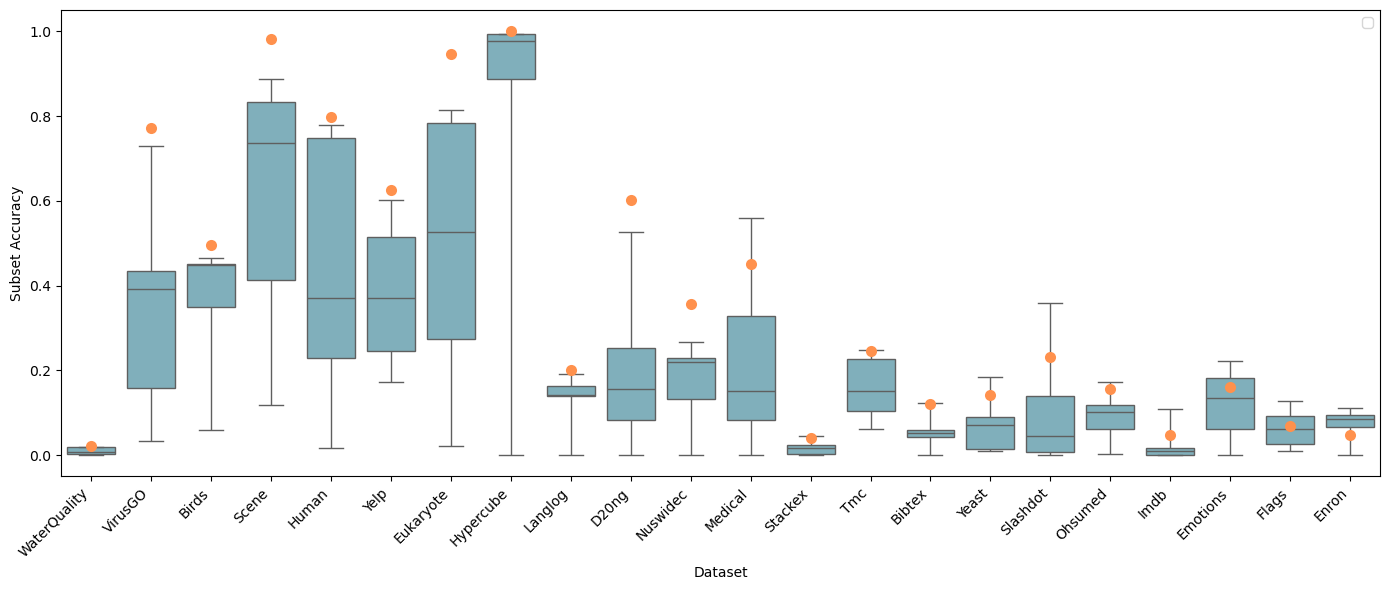

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

melted_df = filtered_df.melt(id_vars=['Dataset'], var_name='Method', value_name='Subset Accuracy')

boxplot_df = melted_df[melted_df['Method'] != 'iHomer']
ihomer_df_plot = melted_df[melted_df['Method'] == 'iHomer']

percentiles = {}
for dataset in filtered_df['Dataset']:
    values = boxplot_df[boxplot_df['Dataset'] == dataset]['Subset Accuracy'].values
    ihomer_value = ihomer_df_plot[ihomer_df_plot['Dataset'] == dataset]['Subset Accuracy'].values[0]
    percentile = np.sum(values < ihomer_value) / len(values)
    percentiles[dataset] = percentile

ordered_datasets = sorted(percentiles.keys(), key=lambda d: -percentiles[d])

boxplot_df['Dataset'] = pd.Categorical(boxplot_df['Dataset'], categories=ordered_datasets, ordered=True)
ihomer_df_plot['Dataset'] = pd.Categorical(ihomer_df_plot['Dataset'], categories=ordered_datasets, ordered=True)

plt.figure(figsize=(14, 6))
sns.boxplot(
    data=boxplot_df,
    x='Dataset',
    y='Subset Accuracy',
    whis=[0, 100],
    showfliers=False,
    color='#76b5c5'  # azul clarinho
)
sns.stripplot(
    data=ihomer_df_plot,
    x='Dataset',
    y='Subset Accuracy',
    color='#ff914d',  # laranja
    size=8,
    marker='o') #,   label='iHomer')

plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig("subset_acc_ordered_boxplot_ihomer_colored.png")
plt.show()

Successfully read data with 22 rows
Available columns: ['Dataset', 'MLHAT', 'KNN', 'NB', 'AMR', 'HT', 'HAT', 'EFDT', 'SGT', 'MT', 'ARF', 'AMF', 'ABALR', 'ABOLR', 'MLBELS', 'MLHT', 'MLHTPS', 'iSOUPT', 'iHomer']

Using 22 datasets for CDD:
['Flags', 'WaterQuality', 'Emotions', 'VirusGO', 'Birds', 'Yeast', 'Scene', 'Human', 'Yelp', 'Medical', 'Eukaryote', 'Slashdot', 'Enron', 'Hypercube', 'Langlog', 'Tmc', 'Ohsumed', 'D20ng', 'Bibtex', 'Nuswidec', 'Imdb', 'Average']

Average Ranks by Method:
SGT: 2.000
MLHT: 4.227
NB: 5.477
MLHTPS: 6.500
MLBELS: 7.045
MT: 7.909
EFDT: 9.477
KNN: 9.727
HT: 10.477
AMF: 10.500
HAT: 10.659
AMR: 11.500
MLHAT: 11.636
iSOUPT: 11.727
ABOLR: 12.409
ABALR: 12.955
iHomer: 13.182
ARF: 13.591


/var/folders/s1/wyqtc_h530bfgwyvd9_3gtbr0000gn/T/ipykernel_96872/946390620.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


CDD plot saved as PDF at: /Users/llns2/Documents/GitHub/iHomer/figured pdf for paper/hamming_cdd.pdf


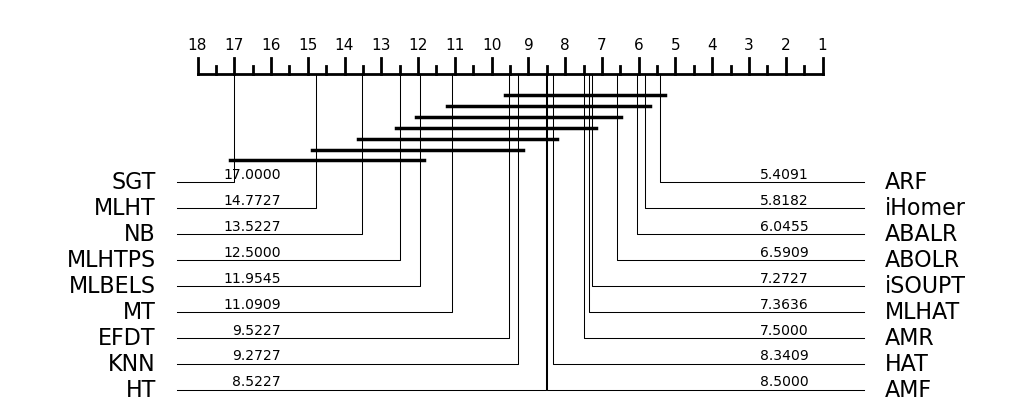

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from aeon.visualisation import plot_critical_difference

merged_data_path = 'hamming.csv'

def generate_cdd_for_accuracy(data_path):
    df = pd.read_csv(data_path)
    print(f"Successfully read data with {len(df)} rows")
    print(f"Available columns: {df.columns.tolist()}")
    
    df = df.dropna(axis=1, how='all')
    
    methods = df.columns.drop('Dataset')
    df = df.dropna(subset=methods, thresh=len(methods)//2)
    
    df = df.fillna(0)
    
    print(f"\nUsing {len(df)} datasets for CDD:")
    print(df['Dataset'].tolist())
    
    cdd_df = df.melt(id_vars='Dataset',
                     value_vars=df.columns.drop('Dataset'),
                     var_name='classifier_name',
                     value_name='accuracy')
    
    cdd_df.columns = ['dataset_name', 'classifier_name', 'accuracy']
    
    cdd_df['accuracy'] = pd.to_numeric(cdd_df['accuracy'], errors='coerce')
    
    pivot_df = cdd_df.pivot(index='dataset_name', columns='classifier_name', values='accuracy')
    ranks = pivot_df.rank(axis=1, method='average', ascending=False, na_option='bottom') ####TRUE NOT FALSE
    
    avg_ranks = ranks.mean()
    print("\nAverage Ranks by Method:")
    for method, rank in avg_ranks.sort_values().items():
        print(f"{method}: {rank:.3f}")
    
    scores = ranks.to_numpy()
    labels = list(ranks.columns)
    
    fig, ax = plot_critical_difference(scores, labels, test='nemenyi', alpha=0.05)
    # ax.set_title("Subset Accuracy Scores")
    
    fig.set_size_inches(10, 4)
    plt.tight_layout()
    
    output_path = '/Users/llns2/Documents/GitHub/iHomer/figured pdf for paper/hamming_cdd.pdf'
    plt.savefig(output_path, format='pdf', dpi=300, bbox_inches='tight')
    print(f"CDD plot saved as PDF at: {output_path}")
    plt.show()

generate_cdd_for_accuracy(merged_data_path)

Successfully read data with 24 rows
Available columns: ['Dataset', 'MLHAT', 'KNN', 'NB', 'AMR', 'HT', 'HAT', 'EFDT', 'SGT', 'MT', 'ARF', 'AMF', 'ABALR', 'ABOLR', 'MLBELS', 'MLHT', 'MLHTPS', 'iSOUPT', 'iHomer']

Using 24 datasets for CDD:
['Flags', 'WaterQuality', 'Emotions', 'VirusGO', 'Birds', 'Yeast', 'Scene', 'Human', 'Yelp', 'Medical', 'Eukaryote', 'Slashdot', 'Enron', 'Hypercube', 'Langlog', 'Stackex', 'Tmc', 'Ohsumed', 'D20ng', 'Bibtex', 'Nuswidec', 'Imdb', 'Average', 'Avg Rank']

Average Ranks by Method:
SGT: 3.062
NB: 5.083
MT: 6.125
MLHTPS: 7.500
AMF: 8.500
HT: 8.750
MLHT: 9.208
EFDT: 9.646
HAT: 9.729
AMR: 9.812
ARF: 10.042
iSOUPT: 10.125
MLBELS: 10.458
ABALR: 10.833
ABOLR: 10.958
KNN: 11.500
MLHAT: 14.083
iHomer: 15.583
CDD plot saved as PDF at: /Users/llns2/Documents/GitHub/iHomer/figured pdf for paper/acc_cdd.pdf


/var/folders/s1/wyqtc_h530bfgwyvd9_3gtbr0000gn/T/ipykernel_96872/4095435110.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


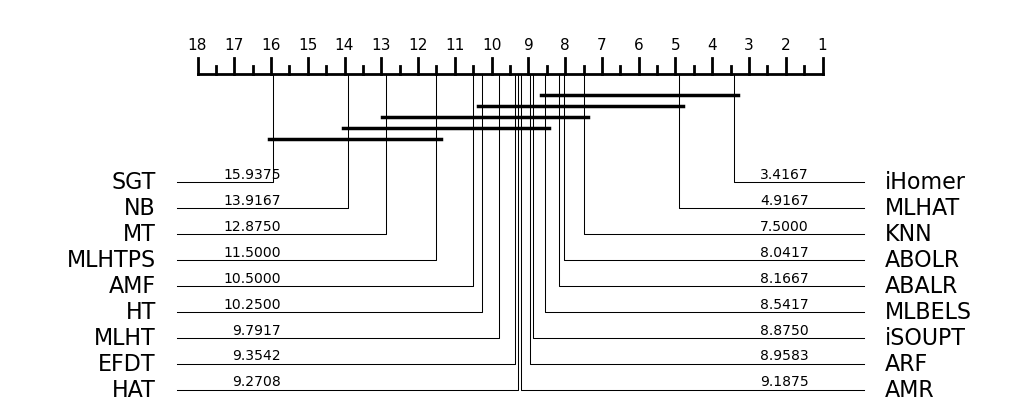

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from aeon.visualisation import plot_critical_difference


merged_data_path = 'subset_acc.csv'

def generate_cdd_for_accuracy(data_path):
    df = pd.read_csv(data_path)
    print(f"Successfully read data with {len(df)} rows")
    print(f"Available columns: {df.columns.tolist()}")
    
    df = df.dropna(axis=1, how='all')
    
    methods = df.columns.drop('Dataset')
    df = df.dropna(subset=methods, thresh=len(methods)//2)
    
    df = df.fillna(0)
    
    print(f"\nUsing {len(df)} datasets for CDD:")
    print(df['Dataset'].tolist())
    
    cdd_df = df.melt(id_vars='Dataset',
                     value_vars=df.columns.drop('Dataset'),
                     var_name='classifier_name',
                     value_name='accuracy')
    
    cdd_df.columns = ['dataset_name', 'classifier_name', 'accuracy']
    
    cdd_df['accuracy'] = pd.to_numeric(cdd_df['accuracy'], errors='coerce')
    
    pivot_df = cdd_df.pivot(index='dataset_name', columns='classifier_name', values='accuracy')
    ranks = pivot_df.rank(axis=1, method='average', ascending=True, na_option='bottom')
    
    avg_ranks = ranks.mean()
    print("\nAverage Ranks by Method:")
    for method, rank in avg_ranks.sort_values().items():
        print(f"{method}: {rank:.3f}")
    
    scores = ranks.to_numpy()
    labels = list(ranks.columns)
    fig, ax = plot_critical_difference(scores, labels, test='nemenyi', alpha=0.05)

    fig.set_size_inches(10, 4)
    plt.tight_layout()
    
    
    output_path = '/Users/llns2/Documents/GitHub/iHomer/acc_cdd.pdf'
    plt.savefig(output_path, format='pdf', dpi=300, bbox_inches='tight')
    print(f"CDD plot saved as PDF at: {output_path}")
    
    plt.show()

generate_cdd_for_accuracy(merged_data_path)

Successfully read data with 23 rows
Available columns: ['Dataset', 'MLHAT', 'KNN', 'NB', 'AMR', 'HT', 'HAT', 'EFDT', 'SGT', 'MT', 'ARF', 'AMF', 'ABALR', 'ABOLR', 'MLBELS', 'MLHT', 'MLHTPS', 'iSOUPT', 'iHomer']

Using 23 datasets for CDD:
['Flags', 'WaterQuality', 'Emotions', 'VirusGO', 'Birds', 'Yeast', 'Scene', 'Human', 'Yelp', 'Medical', 'Eukaryote', 'Slashdot', 'Enron', 'Hypercube', 'Langlog', 'Stackex', 'Tmc', 'Ohsumed', 'D20ng', 'Bibtex', 'Nuswidec', 'Imdb', 'Average']

Average Ranks by Method:
SGT: 4.043
MT: 5.043
MLHT: 5.174
MLHTPS: 5.478
NB: 6.130
HT: 8.543
AMF: 8.565
ARF: 9.870
HAT: 10.000
AMR: 10.348
iSOUPT: 10.652
ABALR: 10.826
ABOLR: 10.826
KNN: 10.826
EFDT: 11.326
MLBELS: 13.261
MLHAT: 15.000
iHomer: 15.087
CDD plot saved as PDF at: /Users/llns2/Documents/GitHub/iHomer/figured pdf for paper/micro_cdd.pdf


/var/folders/s1/wyqtc_h530bfgwyvd9_3gtbr0000gn/T/ipykernel_96872/2498225937.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


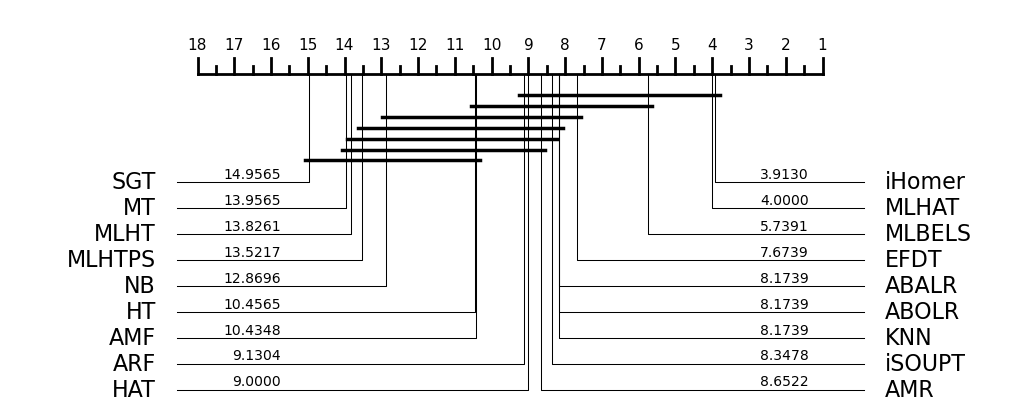

In [ ]:

merged_data_path = 'micro_f1.csv'

def generate_cdd_for_accuracy(data_path):
    df = pd.read_csv(data_path)
    print(f"Successfully read data with {len(df)} rows")
    print(f"Available columns: {df.columns.tolist()}")
    
    df = df.dropna(axis=1, how='all')
    
    methods = df.columns.drop('Dataset')
    df = df.dropna(subset=methods, thresh=len(methods)//2)
    
    df = df.fillna(0)
    
    print(f"\nUsing {len(df)} datasets for CDD:")
    print(df['Dataset'].tolist())
    
   
    cdd_df = df.melt(id_vars='Dataset',
                     value_vars=df.columns.drop('Dataset'),
                     var_name='classifier_name',
                     value_name='accuracy')
    
    cdd_df.columns = ['dataset_name', 'classifier_name', 'accuracy']
    
    cdd_df['accuracy'] = pd.to_numeric(cdd_df['accuracy'], errors='coerce')
    
    pivot_df = cdd_df.pivot(index='dataset_name', columns='classifier_name', values='accuracy')
    ranks = pivot_df.rank(axis=1, method='average', ascending=True, na_option='bottom')
    
    avg_ranks = ranks.mean()
    print("\nAverage Ranks by Method:")
    for method, rank in avg_ranks.sort_values().items():
        print(f"{method}: {rank:.3f}")
    
    scores = ranks.to_numpy()
    labels = list(ranks.columns)
    
    fig, ax = plot_critical_difference(scores, labels, test='nemenyi', alpha=0.05)
    # ax.set_title("Micro F1 Scores")
    
    fig.set_size_inches(10, 4)
    plt.tight_layout()
    output_path = '/Users/llns2/Documents/GitHub/iHomer/figured pdf for paper/micro_cdd.pdf'
    plt.savefig(output_path, format='pdf', dpi=300, bbox_inches='tight')
    print(f"CDD plot saved as PDF at: {output_path}")
    
    plt.show()

generate_cdd_for_accuracy(merged_data_path)

Successfully read data with 23 rows
Available columns: ['Dataset', 'MLHAT', 'KNN', 'NB', 'AMR', 'HT', 'HAT', 'EFDT', 'SGT', 'MT', 'ARF', 'AMF', 'ABALR', 'ABOLR', 'MLBELS', 'MLHT', 'MLHTPS', 'iSOUPT', 'iHomer']

Using 23 datasets for CDD:
['Flags', 'WaterQuality', 'Emotions', 'VirusGO', 'Birds', 'Yeast', 'Scene', 'Human', 'Yelp', 'Medical', 'Eukaryote', 'Slashdot', 'Enron', 'Hypercube', 'Langlog', 'Stackex', 'Tmc', 'Ohsumed', 'D20ng', 'Bibtex', 'Nuswidec', 'Imdb', 'Average']

Average Ranks by Method:
MLHT: 3.435
MT: 5.652
MLHTPS: 5.826
NB: 6.826
SGT: 7.043
HT: 8.217
AMF: 8.739
ARF: 9.609
HAT: 9.739
iSOUPT: 9.913
ABALR: 10.304
ABOLR: 10.783
AMR: 11.000
KNN: 11.304
EFDT: 11.609
iHomer: 11.913
MLBELS: 12.609
MLHAT: 16.478
CDD plot saved as PDF at: /Users/llns2/Documents/GitHub/iHomer/figured pdf for paper/macro_cdd.pdf


/var/folders/s1/wyqtc_h530bfgwyvd9_3gtbr0000gn/T/ipykernel_96872/759900910.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


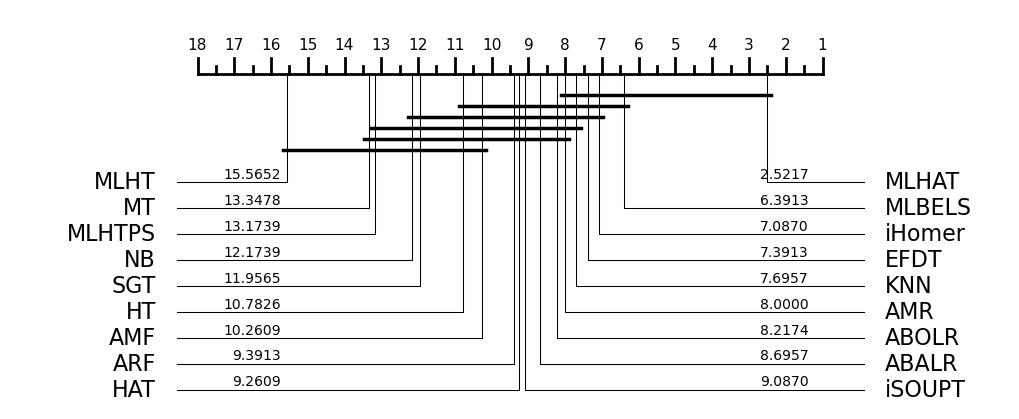

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from aeon.visualisation import plot_critical_difference

merged_data_path = 'macro_f1.csv'

def generate_cdd_for_accuracy(data_path):
    df = pd.read_csv(data_path)
    print(f"Successfully read data with {len(df)} rows")
    print(f"Available columns: {df.columns.tolist()}")
    df = df.dropna(axis=1, how='all')
    
    methods = df.columns.drop('Dataset')
    df = df.dropna(subset=methods, thresh=len(methods)//2)
    
    df = df.fillna(0)
    
    print(f"\nUsing {len(df)} datasets for CDD:")
    print(df['Dataset'].tolist())
    
    cdd_df = df.melt(id_vars='Dataset',
                     value_vars=df.columns.drop('Dataset'),
                     var_name='classifier_name',
                     value_name='accuracy')
    
    cdd_df.columns = ['dataset_name', 'classifier_name', 'accuracy']
    
    cdd_df['accuracy'] = pd.to_numeric(cdd_df['accuracy'], errors='coerce')
    
    pivot_df = cdd_df.pivot(index='dataset_name', columns='classifier_name', values='accuracy')
    ranks = pivot_df.rank(axis=1, method='average', ascending=True, na_option='bottom')
    
    avg_ranks = ranks.mean()
    print("\nAverage Ranks by Method:")
    for method, rank in avg_ranks.sort_values().items():
        print(f"{method}: {rank:.3f}")
    
    scores = ranks.to_numpy()
    labels = list(ranks.columns)
    
    fig, ax = plot_critical_difference(scores, labels, test='nemenyi', alpha=0.05)
    fig.set_size_inches(10, 4)
    plt.tight_layout()
    
    output_path = '/Users/llns2/Documents/GitHub/iHomer/figured pdf for paper/macro_cdd.pdf'
    plt.savefig(output_path, format='pdf', dpi=300, bbox_inches='tight')
    print(f"CDD plot saved as PDF at: {output_path}")
    
    plt.show()

generate_cdd_for_accuracy(merged_data_path)